In [167]:
import os
import seaborn as sns
from sklearn.impute import SimpleImputer
import pandas as pd

In [168]:
FILENAME = "side_effect_data.xlsx"
DATASET_PATH = os.path.join("dataset", FILENAME)

In [169]:
data = pd.read_excel(DATASET_PATH)

In [170]:
column_maps = {"Kullanici_id":"user_id", "Cinsiyet":"gender", "Dogum_Tarihi":"birthdate", "Uyruk":"origin", "Il": "city", "Ilac_Adi":"drug_name","Ilac_Baslangic_Tarihi":"drug_start_date",
               "Ilac_Bitis_Tarihi":"drug_end_date","Yan_Etki":"side_effect", "Yan_Etki_Bildirim_Tarihi":"side_effect_notif_date", "Alerjilerim":"allergies", "Kronik Hastaliklarim": "chronic_diseases",
               "Baba Kronik Hastaliklari":"father_chronic_diseases", "Anne Kronik Hastaliklari":"mother_chronic_diseases","Kiz Kardes Kronik Hastaliklari":"sister_chronic_diseases",
               "Erkek Kardes Kronik Hastaliklari":"brother_chronic_diseases", "Kan Grubu":"blood_type", "Kilo":"weight", "Boy":"height"}

data = data.rename(columns=column_maps)

In [171]:
data.head()

,user_id,gender,birthdate,origin,city,drug_name,drug_start_date,drug_end_date,side_effect,side_effect_notif_date,allergies,chronic_diseases,father_chronic_diseases,mother_chronic_diseases,sister_chronic_diseases,brother_chronic_diseases,blood_type,weight,height
0,107,Male,1960-03-01,Turkiye,Canakkale,trifluoperazine,2022-01-09,2022-03-04,Kabizlik,2022-02-19 18:28:43,Ceviz,"Hipertansiyon, Kan Hastaliklari","Guatr, Hipertansiyon",KOAH,"Kemik Erimesi, Kalp Hastaliklari","Kemik Erimesi, Guatr",B RH-,103.0,191.0
1,140,Male,1939-10-12,Turkiye,Trabzon,fluphenazine hcl,2022-01-09,2022-03-08,Yorgunluk,2022-02-03 20:48:17,Toz,NaN,"Guatr, Diger","Hipertansiyon, Kalp Hastaliklari",,"KOAH, Diyabet",NaN,81.0,181.0
2,2,Female,1976-12-17,Turkiye,Canakkale,warfarin sodium,2022-01-11,2022-03-12,Carpinti,2022-02-04 05:29:20,Muz,"Kalp Hastaliklari, Diyabet","Diyabet, KOAH","Kemik Erimesi, Diyabet","Diyabet, Kemik Erimesi",Diger,B RH-,93.0,158.0
3,83,Male,1977-06-17,Turkiye,Adana,valproic acid,2022-01-04,2022-03-12,Sinirlilik,2022-02-08 01:01:21,Pancar,"Diyabet, Diger","Kalp Hastaliklari, Diger",NaN,Astim,"Kalp Hastaliklari, Kanser",AB RH-,NaN,165.0
4,7,Female,1976-09-03,Turkiye,Izmir,carbamazepine extended release,2022-01-13,2022-03-06,Agizda Farkli Bir Tat,2022-02-12 05:33:06,NaN,"Diyabet, Kalp Hastaliklari","Alzheimer, Hipertansiyon","Kan Hastaliklari, Kemik Erimesi","Diyabet, Diger","Alzheimer, Hipertansiyon",AB RH-,99.0,172.0


In [172]:
user_data = data.iloc[data["user_id"].drop_duplicates().index, :]

## Datetime Features

In [173]:
data["drug_start_day"] = data["drug_start_date"].dt.day
data["drug_end_day"] = data["drug_end_date"].dt.day
data["drug_interval"] = (data["drug_end_date"] - data["drug_start_date"]).dt.days
data["side_effect_notif_day"] = data["side_effect_notif_date"].dt.day
data["side_effect_notif_hour"] = data["side_effect_notif_date"].dt.hour
data["birth_year"] = pd.to_datetime(data["birthdate"]).dt.year

In [174]:
data = data.astype({"user_id":"object"})
data["age_group"] = pd.cut(data["birth_year"],
 bins=[1930, 1960, 1980, 2000, 2010, 2040],
 labels=[1, 2, 3, 4, 5])
data["age"] = 2024 - data["birth_year"].astype(int)
data["bmi"] = (data["weight"] / data["height"]**2) * 10e3

In [175]:
data.describe()

,weight,height,drug_start_day,drug_end_day,drug_interval,side_effect_notif_day,side_effect_notif_hour,birth_year,age,bmi
count,2064.000000,2243.000000,2357.000000,2357.000000,2357.000000,2357.000000,2357.000000,2357.000000,2357.000000,1950.000000
mean,80.863857,174.638431,7.449724,10.684345,62.234620,10.268562,10.243106,1974.409419,49.590581,27.572163
std,18.635269,16.516552,4.069499,5.118675,6.576611,6.245644,7.045983,20.076783,20.076783,8.822664
min,50.000000,145.000000,1.000000,2.000000,47.000000,1.000000,0.000000,1939.000000,13.000000,12.623450
25%,65.000000,160.000000,4.000000,6.000000,58.000000,4.000000,5.000000,1959.000000,32.000000,20.756387
50%,83.000000,176.000000,7.000000,11.000000,62.000000,9.000000,8.000000,1973.000000,51.000000,26.709402
75%,96.000000,187.000000,11.000000,15.000000,67.000000,17.000000,17.000000,1992.000000,65.000000,32.912013
max,110.000000,203.000000,14.000000,19.000000,77.000000,19.000000,23.000000,2011.000000,85.000000,49.979175


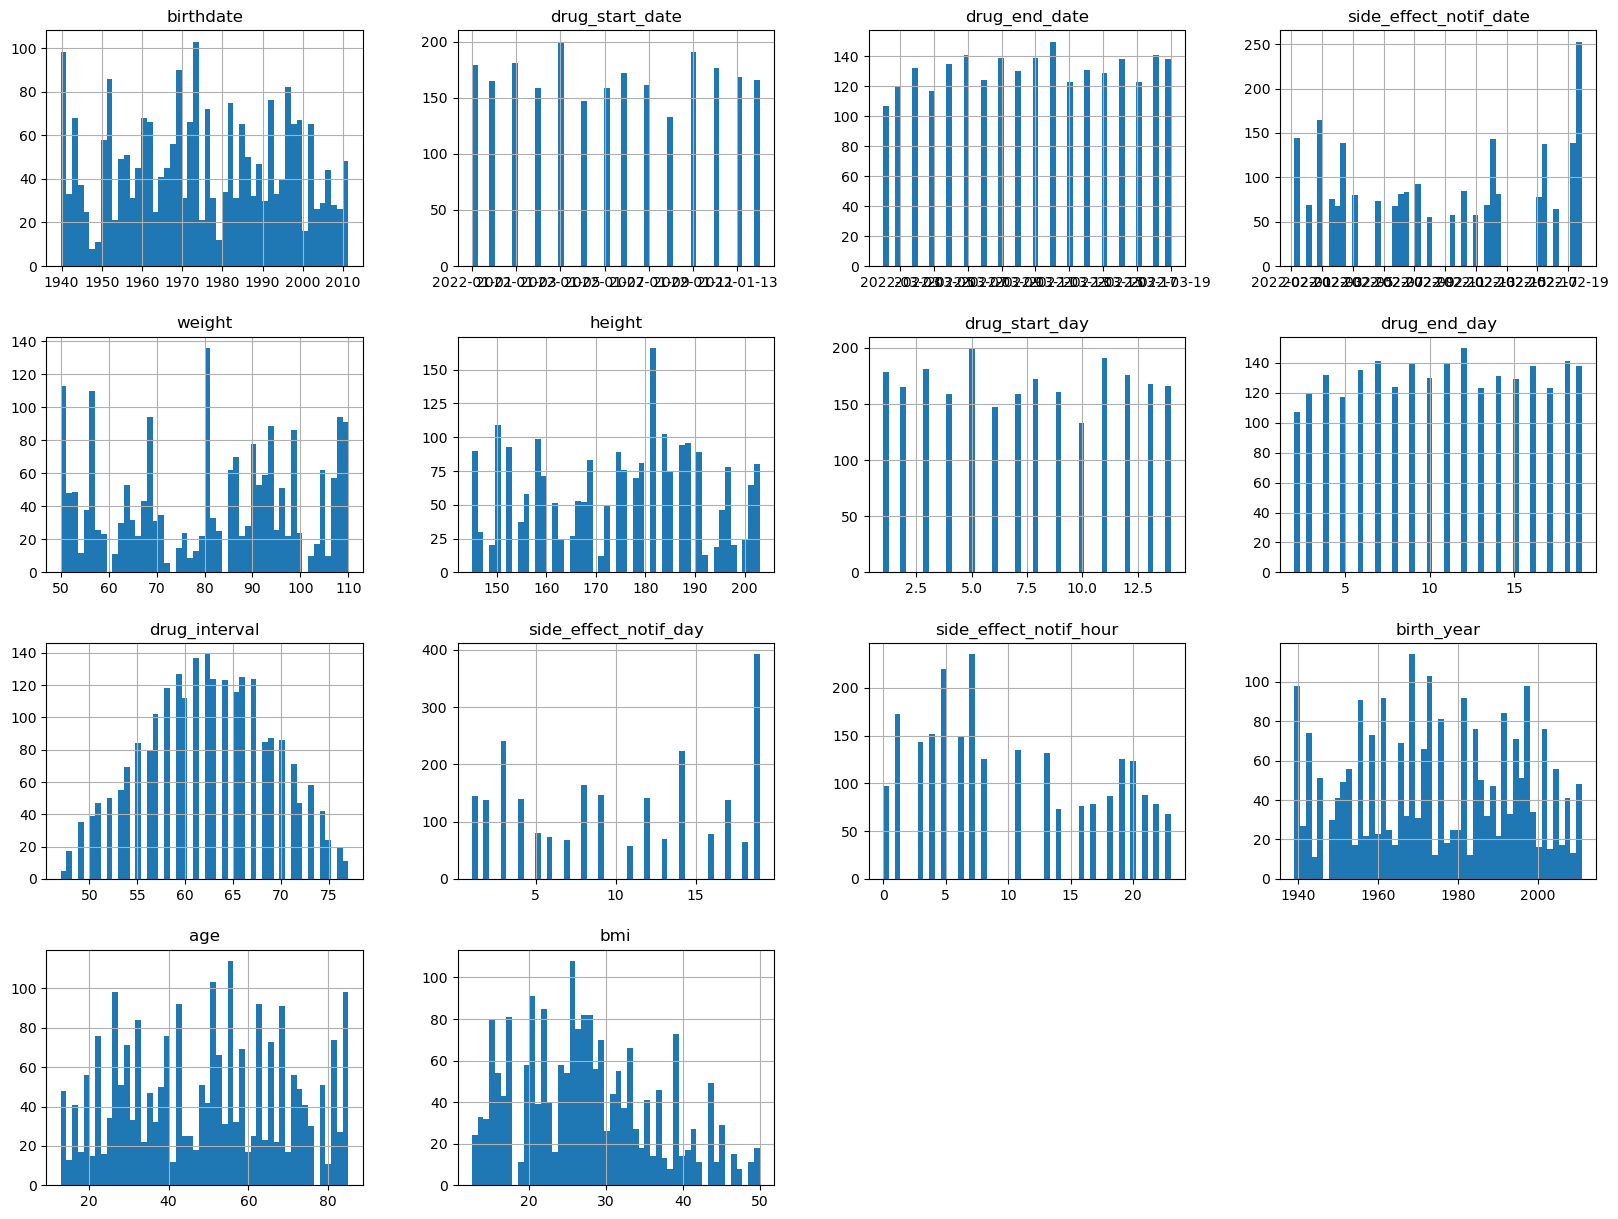

In [176]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
plt.show()

<Axes: >

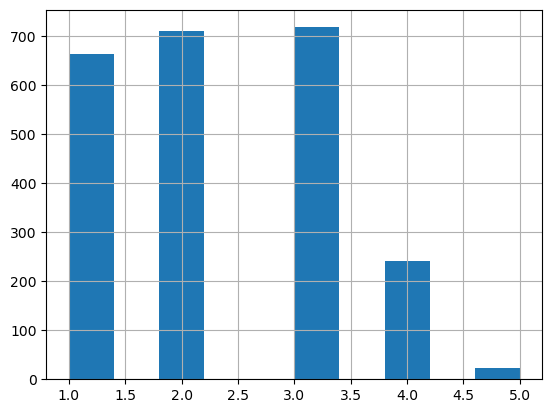

In [177]:
data["age_group"].hist()

### High Correlations
Weight - bmi 
height - bmi
drug_start_day - drug_interval
drug_end_day - drug_interval
birth_year age birth year will be dropped

C:\Users\sceli\AppData\Local\Temp\ipykernel_4828\751783092.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = data.corr()


,weight,height,drug_start_day,drug_end_day,drug_interval,side_effect_notif_day,side_effect_notif_hour,birth_year,age,bmi
weight,1.000000,-0.149016,0.015008,-0.006739,-0.014538,0.000033,-0.006946,-0.026321,0.026321,0.798079
height,-0.149016,1.000000,-0.040572,0.010633,0.033448,-0.005868,-0.018179,0.002952,-0.002952,-0.692869
drug_start_day,0.015008,-0.040572,1.000000,-0.011765,-0.627941,0.021364,-0.009232,-0.010052,0.010052,0.029516
drug_end_day,-0.006739,0.010633,-0.011765,1.000000,0.785595,0.008202,-0.008428,0.017304,-0.017304,-0.010468
drug_interval,-0.014538,0.033448,-0.627941,0.785595,1.000000,-0.006836,-0.000847,0.019688,-0.019688,-0.026466
side_effect_notif_day,0.000033,-0.005868,0.021364,0.008202,-0.006836,1.000000,0.141822,-0.014448,0.014448,-0.003707
side_effect_notif_hour,-0.006946,-0.018179,-0.009232,-0.008428,-0.000847,0.141822,1.000000,0.001765,-0.001765,-0.010752
birth_year,-0.026321,0.002952,-0.010052,0.017304,0.019688,-0.014448,0.001765,1.000000,-1.000000,-0.055783
age,0.026321,-0.002952,0.010052,-0.017304,-0.019688,0.014448,-0.001765,-1.000000,1.000000,0.055783
bmi,0.798079,-0.692869,0.029516,-0.010468,-0.026466,-0.003707,-0.010752,-0.055783,0.055783,1.000000


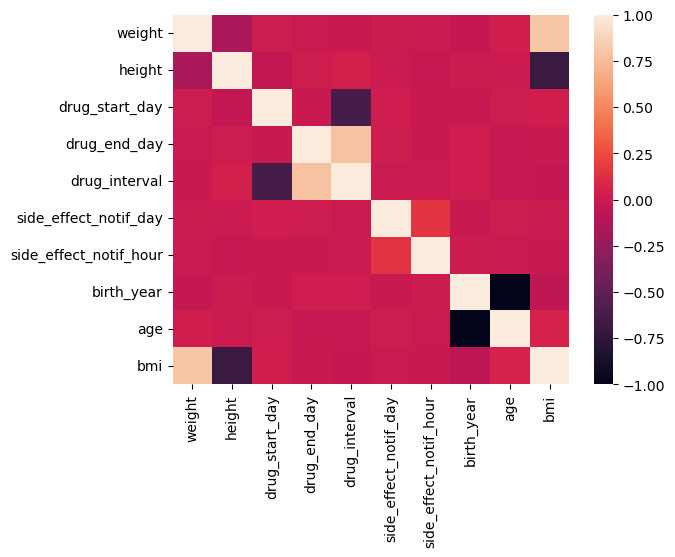

In [178]:
corr_mat = data.corr()
display(corr_mat)
sns.heatmap(corr_mat)
plt.show()

### Sklearn Train Test Split

In [179]:
from sklearn.model_selection import train_test_split
import numpy as np

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)


### Stratified Split

In [180]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["age_group"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]


#### Normal test set vs Stratified test set age_group class ratio 1(-1930) to 5(2010-) 

In [181]:
strat_test_set["age_group"].value_counts() / len(strat_test_set)

3    0.305085
2    0.300847
1    0.281780
4    0.101695
5    0.010593
Name: age_group, dtype: float64

In [182]:
test_set["age_group"].value_counts() /len(test_set)

2    0.305085
3    0.302966
1    0.292373
4    0.086864
5    0.012712
Name: age_group, dtype: float64

In [183]:
for set_ in (strat_train_set, strat_test_set):
 set_.drop("age_group", axis=1, inplace=True)


## Traininig Data

In [184]:
df_train = strat_train_set.copy()
df_train.head()

,user_id,gender,birthdate,origin,city,drug_name,drug_start_date,drug_end_date,side_effect,side_effect_notif_date,...,weight,height,drug_start_day,drug_end_day,drug_interval,side_effect_notif_day,side_effect_notif_hour,birth_year,age,bmi
454,17,Male,1969-07-26,Turkiye,Eskisehir,olanzapine odt,2022-01-12,2022-03-16,Tansiyon Dusuklugu,2022-02-14 03:35:01,...,91.0,145.0,12,16,63,14,3,1969,55,43.281807
2049,56,NaN,1998-10-04,Turkiye,Mersin,desonide lotion,2022-01-08,2022-03-05,Agizda Farkli Bir Tat,2022-02-12 05:33:06,...,59.0,191.0,8,5,56,12,5,1998,26,16.172802
1342,41,Female,1956-10-09,Turkiye,Eskisehir,dipyridamole,2022-01-09,2022-03-16,Gec Bosalma,2022-02-14 07:26:11,...,51.0,182.0,9,16,66,14,7,1956,68,15.396691
616,71,Male,1979-08-18,Turkiye,Canakkale,chlordiazepoxide-amitriptyline,2022-01-03,2022-03-09,Karin Agrisi,2022-02-13 13:55:37,...,94.0,197.0,3,9,65,13,13,1979,45,24.221186
861,118,Male,1946-05-10,Turkiye,Izmir,triamcinolone cream,2022-01-14,2022-03-10,Gormede Bulaniklik,2022-02-16 22:10:35,...,85.0,181.0,14,10,55,16,22,1946,78,25.945484


## Missing Values

In [296]:
def null_values(df):
    print(df.isnull().sum().sort_values(ascending=False))

null_values(data)

gender                      778
allergies                   484
bmi                         407
chronic_diseases            392
blood_type                  347
weight                      293
city                        227
mother_chronic_diseases     217
father_chronic_diseases     156
brother_chronic_diseases    121
height                      114
sister_chronic_diseases      97
side_effect_notif_date        0
side_effect                   0
drug_end_date                 0
drug_start_date               0
drug_name                     0
origin                        0
birthdate                     0
drug_start_day                0
drug_end_day                  0
drug_interval                 0
side_effect_notif_day         0
side_effect_notif_hour        0
birth_year                    0
age_group                     0
age                           0
user_id                       0
dtype: int64


In [297]:
def empty_imputer(df, missing_column):
    df.loc[df[missing_column].isnull(), [missing_column]] = "Yok"
    return df

In [298]:
# Boy ve kilo için doldurma yapma
def imputer_missing_values(df, missing_column, target_column, th):
    for index, row in df[df[missing_column].isnull()].iterrows():
        sample = df.loc[(df[target_column] >= row[target_column] - th) & (df[target_column] <= row[target_column] + th), :]
        if row["gender"] is not np.NaN:
            sample = sample.loc[sample["gender"] == row["gender"],:] # same gender
        df.loc[index, [missing_column]] = sample[missing_column].dropna().values.mean()
    return df

In [299]:
def fill_missing_values(df, missing_diseases):
    print(f"Before filling missing data:\n {null_values(df)}")
    # gender
    df = empty_imputer(df, "gender")
    # city
    df = empty_imputer(df, "city")
    # blood type
    df = empty_imputer(df, "blood_type")
    # allergies
    df = empty_imputer(df, "allergies")
    # chronic diseases
    for dis in missing_diseases:
        df = empty_imputer(df, dis)
    # height
    df = imputer_missing_values(df, "height", "weight", 5)
    # weight
    df = imputer_missing_values(df, "weight", "height", 10)
    df["bmi"] = (df["weight"] / df["height"]**2) * 10e3

    print(f"After filling:\n{null_values(df)}")
    return df

In [300]:
def split_disease_column(df, column_name):
    df[column_name] = df[column_name].apply(lambda row: row.split(','))
    df[[column_name+"_1", column_name+"_2"]] = pd.DataFrame(df[column_name].tolist(), index=df.index)
    df = empty_imputer(df, column_name+"_2")
    return df.drop([column_name], axis=1)

In [301]:
missing_diseases = ["chronic_diseases", "mother_chronic_diseases","father_chronic_diseases", "brother_chronic_diseases", "sister_chronic_diseases"]
def preprocess_pipe(df):
    df = fill_missing_values(df, missing_diseases)
    for disease in missing_diseases:
        df = split_disease_column(df, disease)
    df.drop(['birthdate', 'origin', 'drug_start_date', 'drug_end_date','side_effect_notif_date'], axis=1, inplace=True)
    return df    

In [302]:
df_train, df_test = strat_train_set.copy(), strat_test_set.copy()

In [303]:
df_train, df_test = preprocess_pipe(df_train), preprocess_pipe(df_test)

gender                      617
allergies                   372
bmi                         324
chronic_diseases            296
blood_type                  273
weight                      240
city                        180
mother_chronic_diseases     174
father_chronic_diseases     122
brother_chronic_diseases     97
height                       84
sister_chronic_diseases      75
side_effect                   0
drug_end_day                  0
age                           0
birth_year                    0
side_effect_notif_hour        0
side_effect_notif_day         0
drug_interval                 0
birthdate                     0
drug_start_day                0
side_effect_notif_date        0
origin                        0
drug_name                     0
drug_start_date               0
drug_end_date                 0
user_id                       0
dtype: int64
Before filling missing data:
 None
user_id                     0
sister_chronic_diseases     0
age                         

In [304]:
df_train.isnull().sum()

user_id                       0
gender                        0
city                          0
drug_name                     0
side_effect                   0
allergies                     0
blood_type                    0
weight                        0
height                        0
drug_start_day                0
drug_end_day                  0
drug_interval                 0
side_effect_notif_day         0
side_effect_notif_hour        0
birth_year                    0
age                           0
bmi                           0
chronic_diseases_1            0
chronic_diseases_2            0
mother_chronic_diseases_1     0
mother_chronic_diseases_2     0
father_chronic_diseases_1     0
father_chronic_diseases_2     0
brother_chronic_diseases_1    0
brother_chronic_diseases_2    0
sister_chronic_diseases_1     0
sister_chronic_diseases_2     0
dtype: int64

In [315]:
len(df_train.columns), len(df_test.columns)

(27, 27)

## Irrelevant Features

In [316]:
num_attrs = ["weight", "height", "birth_year", "age", "bmi", "drug_start_day", "drug_end_day", "drug_interval", "side_effect_notif_day", "side_effect_notif_hour"]
ord_cat_attrs = []
nom_cat_attrs = ["user_id", "gender","city", "drug_name", "allergies", "chronic_diseases_1", "chronic_diseases_2", "father_chronic_diseases_1","father_chronic_diseases_2", 
                 "mother_chronic_diseases_1","mother_chronic_diseases_2", "sister_chronic_diseases_1","sister_chronic_diseases_2", "brother_chronic_diseases_1","brother_chronic_diseases_2", "blood_type"]
len(num_attrs) + len(ord_cat_attrs) + len(nom_cat_attrs), len(df_train.columns)

(27, 27)

In [317]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
 ('imputer', SimpleImputer(strategy="median")),
 ('std_scaler', StandardScaler()),
 ])


In [318]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder


full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attrs),
 ("nom_cat", OrdinalEncoder(), nom_cat_attrs)
 ])

test_prepared = full_pipeline.fit_transform(df_test)
train_prepared = full_pipeline.fit_transform(df_train)

In [319]:
train_prepared.shape, test_prepared.shape

((1885, 27), (472, 27))

In [320]:
df_train_prepared = pd.DataFrame(train_prepared, columns=df_train.columns)
df_test_prepared = pd.DataFrame(test_prepared, columns=df_test.columns)

In [321]:
df_test_prepared.isnull().sum()

user_id                       0
gender                        0
city                          0
drug_name                     0
side_effect                   0
allergies                     0
blood_type                    0
weight                        0
height                        0
drug_start_day                0
drug_end_day                  0
drug_interval                 0
side_effect_notif_day         0
side_effect_notif_hour        0
birth_year                    0
age                           0
bmi                           0
chronic_diseases_1            0
chronic_diseases_2            0
mother_chronic_diseases_1     0
mother_chronic_diseases_2     0
father_chronic_diseases_1     0
father_chronic_diseases_2     0
brother_chronic_diseases_1    0
brother_chronic_diseases_2    0
sister_chronic_diseases_1     0
sister_chronic_diseases_2     0
dtype: int64

In [323]:
df_train

,user_id,gender,city,drug_name,side_effect,allergies,blood_type,weight,height,drug_start_day,...,chronic_diseases_1,chronic_diseases_2,mother_chronic_diseases_1,mother_chronic_diseases_2,father_chronic_diseases_1,father_chronic_diseases_2,brother_chronic_diseases_1,brother_chronic_diseases_2,sister_chronic_diseases_1,sister_chronic_diseases_2
454,17,Male,Eskisehir,olanzapine odt,Tansiyon Dusuklugu,Kahve,0 RH-,91.0,145.0,12,...,Astim,Kalp Hastaliklari,,Yok,Astim,Hipertansiyon,Astim,Yok,Hipertansiyon,Yok
2049,56,Yok,Mersin,desonide lotion,Agizda Farkli Bir Tat,Balik,AB RH+,59.0,191.0,8,...,Yok,Yok,Kemik Erimesi,Diyabet,Kanser,Yok,Diyabet,Kan Hastaliklari,Kalp Hastaliklari,Diger
1342,41,Female,Eskisehir,dipyridamole,Gec Bosalma,Havyar,B RH+,51.0,182.0,9,...,Yok,Yok,Alzheimer,Hipertansiyon,Yok,Yok,Hipertansiyon,Kemik Erimesi,Hipertansiyon,Alzheimer
616,71,Male,Canakkale,chlordiazepoxide-amitriptyline,Karin Agrisi,Laktoz,B RH+,94.0,197.0,3,...,Alzheimer,Guatr,Kalp Hastaliklari,Diger,Kanser,Yok,Guatr,Kanser,Kanser,Astim
861,118,Male,Izmir,triamcinolone cream,Gormede Bulaniklik,Toz,Yok,85.0,181.0,14,...,Alzheimer,Diger,Kanser,Guatr,Kalp Hastaliklari,KOAH,KOAH,Kalp Hastaliklari,Diyabet,Kanser
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,14,Yok,Samsun,fluvoxamine maleate,Kas Agrisi,Balik,AB RH-,68.0,184.0,8,...,Hipertansiyon,Diyabet,Hipertansiyon,Kalp Hastaliklari,Astim,Diyabet,Kan Hastaliklari,Hipertansiyon,Guatr,Yok
999,64,Yok,Samsun,"betamethasone dipropionate aerosol, spray with...",Yorgunluk,Karaciger,AB RH-,69.0,187.0,1,...,Alzheimer,Astim,Kemik Erimesi,Astim,KOAH,Diger,Kemik Erimesi,Kan Hastaliklari,Kan Hastaliklari,Alzheimer
333,144,Male,Ankara,halobetasol propionate foam,Kabizlik,Yok,B RH+,55.0,203.0,1,...,Hipertansiyon,KOAH,Astim,Kalp Hastaliklari,Astim,Kanser,,Yok,Kemik Erimesi,Alzheimer
295,76,Yok,Malatya,doxepin hcl cream,Huzursuzluk,Kabak Cekirdegi,B RH-,52.0,158.0,5,...,Kan Hastaliklari,Astim,Alzheimer,Hipertansiyon,Yok,Yok,Diyabet,Alzheimer,Kan Hastaliklari,Kanser


# Ordinal Encoder Feature Importance

In [322]:
from sklearn.ensemble import RandomForestClassifier

target_var = ["side_effect"]

X_train, y_train = df_train.drop(target_var, axis=1).values, df_train[target_var].values
X_test, y_test = df_test.drop(target_var, axis=1).values, df_test[target_var].values

X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.fit_transform(X_test)

feature_names = X_train.columns.values

clf = RandomForestClassifier().fit(X_train, y_train)

importances = clf.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df)

ValueError: A given column is not a column of the dataframe

In [523]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, 

ord_enc = OneHotEncoder()
nom_cat_attrs = ["sister_chronic_diseases_2"]
# drug_name sıkıntı, chronin diseases 1 ve 2 diye ayır
df_train_cat = df_train[nom_cat_attrs]

encoded = ord_enc.fit_transform(df_train_cat)
encoded.toarray()

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Outliers

In [23]:
def plot_IQR(df, col_name):
    df.plot.box(column=col_name, by="gender", figsize=(10,8))
    plt.show()

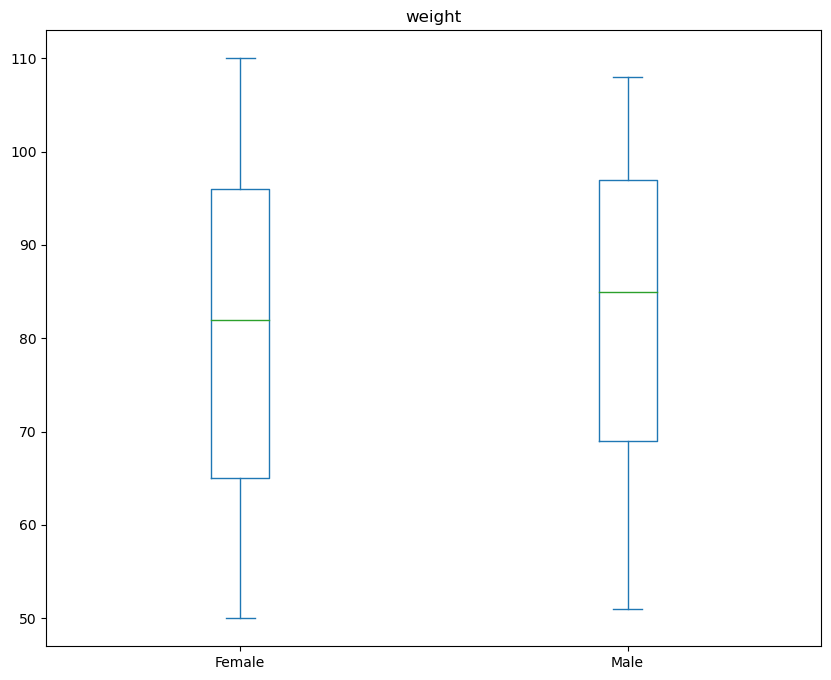

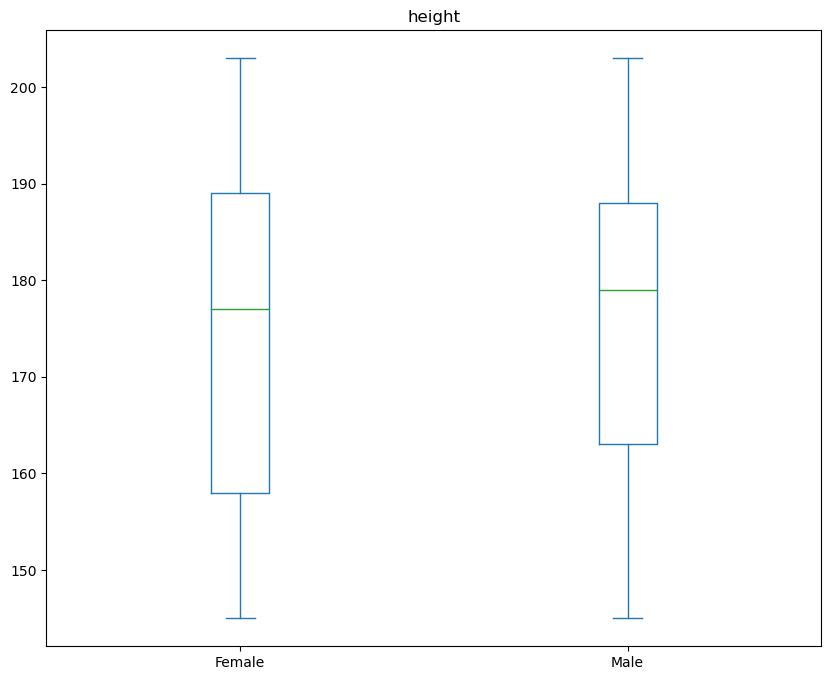

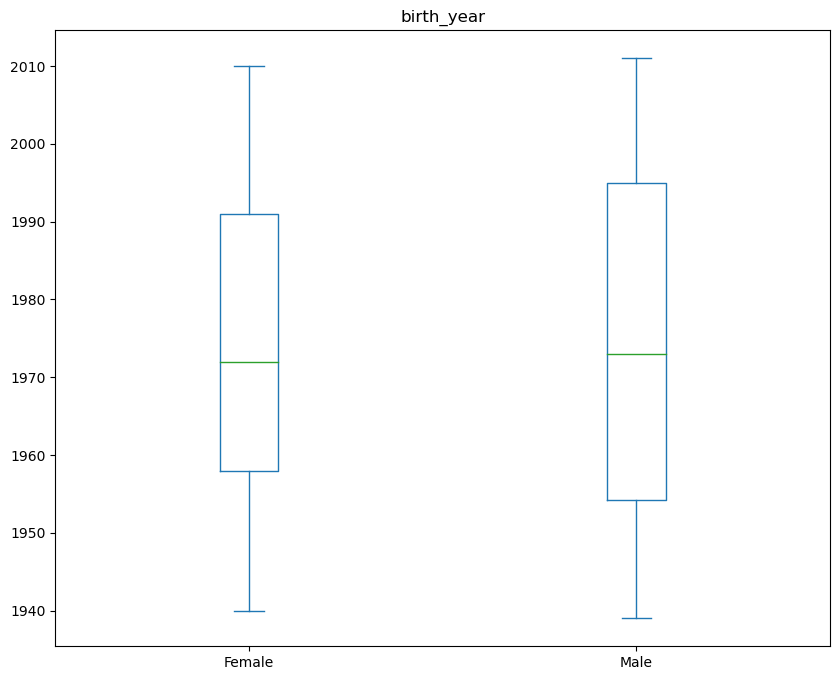

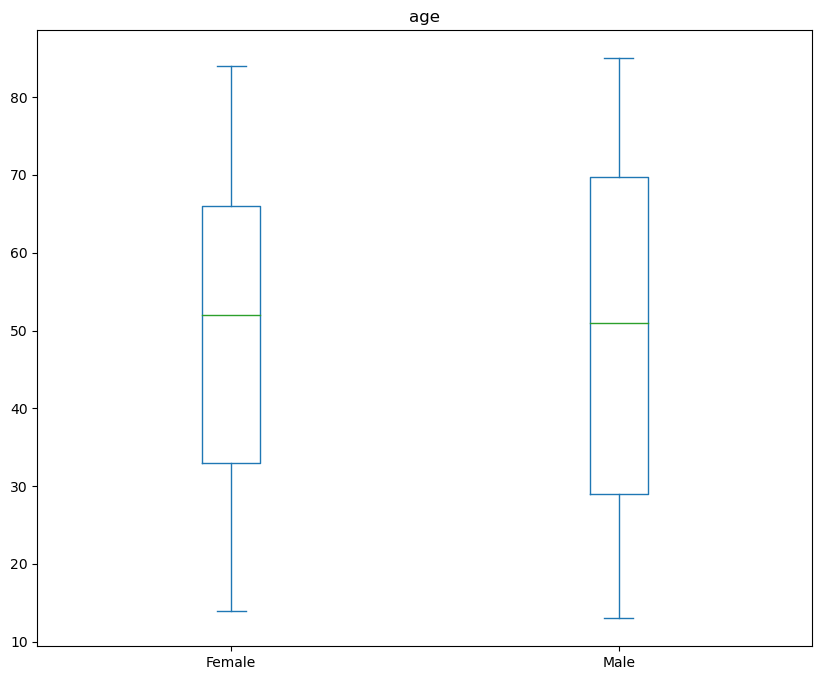

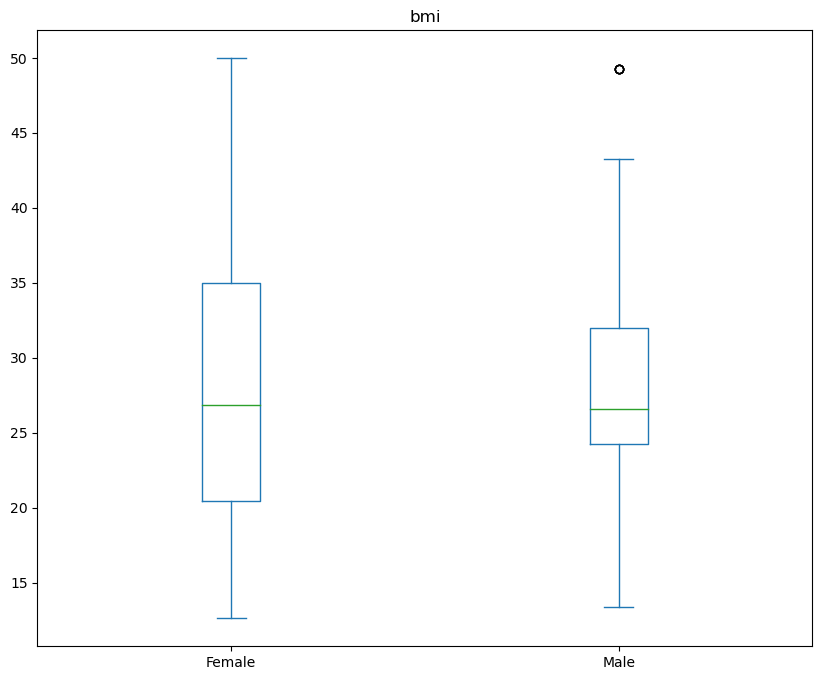

In [24]:
for col in num_attrs:
    plot_IQR(df_train,col)

In [51]:
def outlier_detect(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1*IQR
    upper = Q3 + 1*IQR
    print('Before data preprocess:')
    print('Skewness:', df.skew())
    print(df.describe())
    print('Median:\n', df.median())
    print('IQR:\n', IQR)
    print("Lower - Uppeer bound", lower,'-',upper)

In [52]:
outlier_detect(df_train[num_attrs])

Before data preprocess:
Skewness: weight       -0.115116
height       -0.126046
birth_year   -0.021427
age           0.021427
bmi           0.440620
dtype: float64
            weight       height   birth_year          age          bmi
count  1645.000000  1801.000000  1885.000000  1885.000000  1561.000000
mean     80.817021   174.688506  1974.536340    49.463660    27.508416
std      18.772325    16.428435    20.012904    20.012904     8.851771
min      50.000000   145.000000  1939.000000    13.000000    12.623450
25%      65.000000   160.000000  1959.000000    32.000000    20.626562
50%      82.000000   178.000000  1973.000000    51.000000    26.709402
75%      96.000000   187.000000  1992.000000    65.000000    32.912013
max     110.000000   203.000000  2011.000000    85.000000    49.979175
Median:
 weight          82.000000
height         178.000000
birth_year    1973.000000
age             51.000000
bmi             26.709402
dtype: float64
IQR:
 weight        31.000000
height       

[]

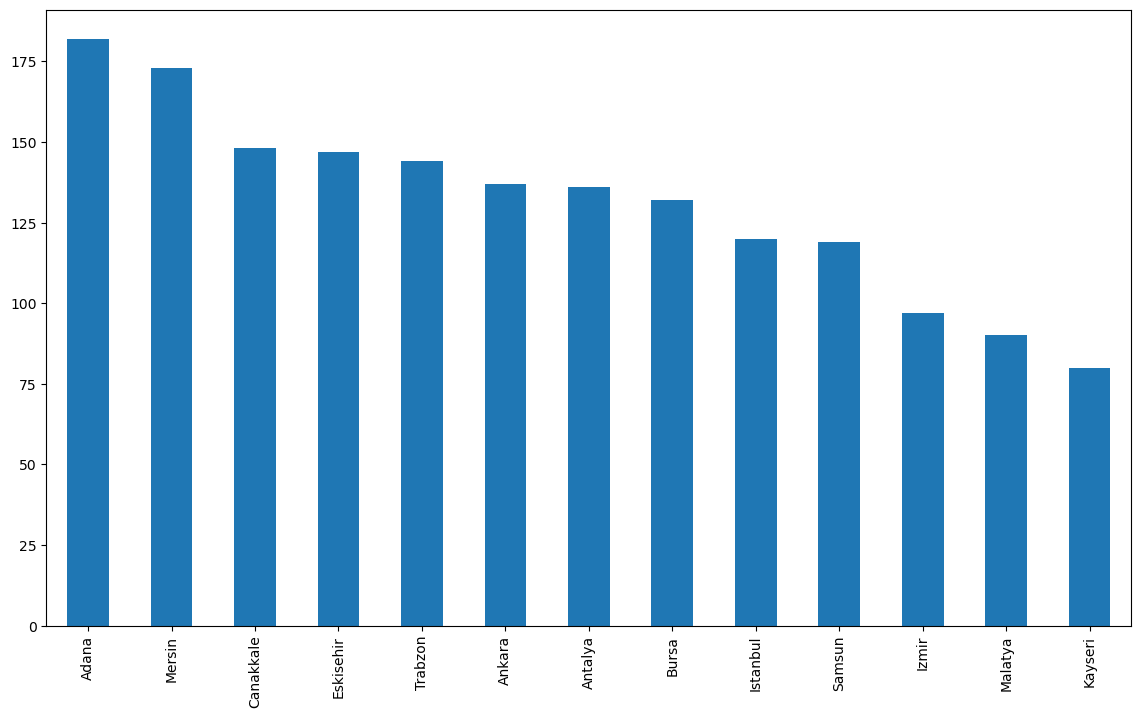

In [61]:
def plot_categorie_spread(df, col_name):
    df[col_name].value_counts().plot(kind="bar", figsize=(14,8))
    plt.show()

In [ ]:
for 